# Implementation of learning sine function with noise (ibm fake-device)
Based upon: https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/

In [1]:
# imports
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeArmonkV2

#use device with only one qubit
fake_backend = FakeArmonkV2()

# passing a string in backend would result in an error
fake_dev = qml.device('qiskit.remote', wires=1, backend=fake_backend)

## Construct variational circuit (state_preparation + ansatz)¶

In [3]:
# We use the datapoint as angle for state-preparation
# We have 3 parameters for Rotation -> all states on bloch-sphere can be reached!

@qml.qnode(fake_dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

/tmp/ipykernel_16569/3845586471.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


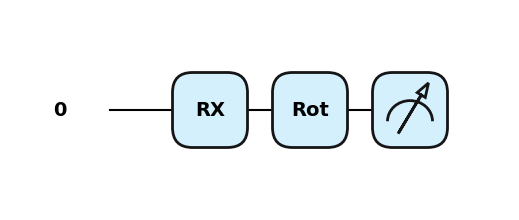

In [4]:
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_circuit)("datapoint", ["param0", "param1", "param"])
fig.show()

## Define loss and accuracy functions needed for optimizing parameters¶

In [5]:
# calculate accuracy with L1-norm
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-2 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [6]:
# define function calculating the square mean = ((labels-predictions)**2)/N
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [7]:
# first approach: calculate loss by L2-norm
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.

    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [8]:
#Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(x, params)  for x in X]
    # We calculate the cost including any classical postprocessing
    #cost = loss_func(predictions)

    # We use the mean(L2) for optimization
    cost = square_loss(Y, predictions)
    return cost

## Load data and initialize parameters and bias

In [9]:
# define number of date points taken for training
num_datapoints = 20

In [10]:
# We create the training Data
X = np.linspace(0, 2*np.pi, num_datapoints) # 20 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 20 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0.2, 2*np.pi+0.2, num_datapoints)
Y_test = np.sin(X_test) # The outputs for the test datapoints

In [11]:
params = np.array([0.1,0.1,0.1],requires_grad=True)

## Instantiate Optimizer and start training

In [12]:
opt = qml.GradientDescentOptimizer(stepsize=0.3)

In [13]:
costs = []

In [14]:
for i in range (200):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    if i%10 == 0:
        # We print the result after every 10 steps
        costs.append(cost_fn(params))
        print(f'Step = {i} Cost = {costs[-1]}')

Step = 0 Cost = 0.9601967026330425
Step = 10 Cost = 0.2390984714903209
Step = 20 Cost = 0.012566687561948078
Step = 30 Cost = 0.00463559386196154
Step = 40 Cost = 0.004157616538419709
Step = 50 Cost = 0.004291784631199962
Step = 60 Cost = 0.0032244468537678357
Step = 70 Cost = 0.0023018034107095413
Step = 80 Cost = 0.0020653983168045314
Step = 90 Cost = 0.0017383474187827302
Step = 100 Cost = 0.0022765601711667366
Step = 110 Cost = 0.0016642365448541814
Step = 120 Cost = 0.0018701504741058747
Step = 130 Cost = 0.002001011345937376
Step = 140 Cost = 0.0018104626516257526
Step = 150 Cost = 0.0013492383118607445
Step = 160 Cost = 0.0015190067374650615
Step = 170 Cost = 0.0016612482447100458
Step = 180 Cost = 0.0011984298761739825
Step = 190 Cost = 0.0015269629699999013


## Evaluate results

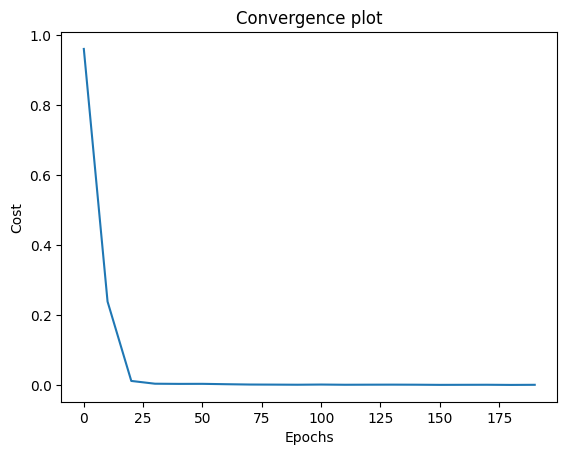

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(0,200,10), costs)
ax1.set(xlabel='Epochs', ylabel='Cost', title='Convergence plot')
plt.show()

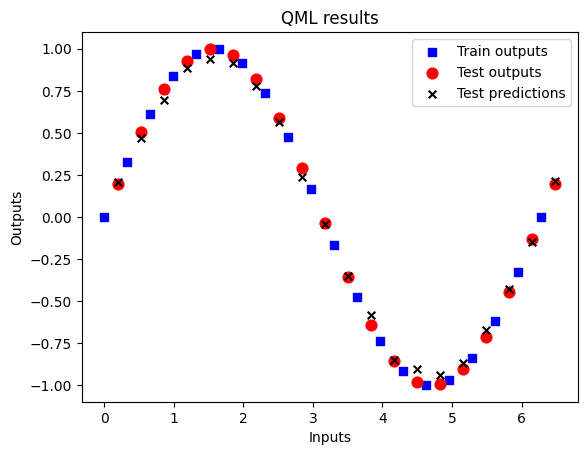

In [16]:
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

In [17]:
acc_val = accuracy(Y_test, test_predictions)
print(f"Accuracy: {acc_val}")

Accuracy: 0.15


## Try generalizing

In [18]:
X_test2 = np.linspace(0.2, 4*np.pi+0.2, num_datapoints*2)
Y_test2 = np.sin(X_test2) # The outputs for the test datapoints

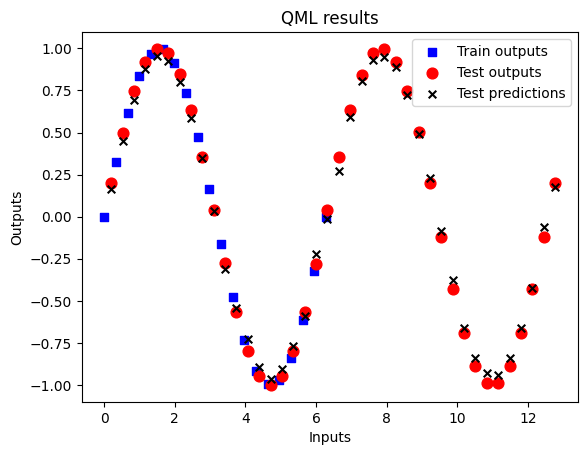

In [19]:
test_predictions = []
for x_test in X_test2:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test2,Y_test2, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test2,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()